In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [8]:
with open("../configs/config.json", "r") as f:
    config = json.load(f)

input_dim = config["input_dim"]
num_classes = config["num_classes"]
train_batch_size = config["train_batch_size"]
eval_batch_size = config.get("eval_batch_size", train_batch_size)
epochs = config["epochs"]
learning_rate = config["learning_rate"]
dataset_path = config["dataset_path"]
save_model_path = config["save_model_path"]

In [10]:
class Hawkeye(nn.Module):
    def __init__(self, input_dim=23, num_classes=15):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, features):
        return self.classifier(features)

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Train", leave=False):
        features = batch["features"].to(device)
        labels = batch["accept_length"].to(device)
        optimizer.zero_grad()
        logits = model(features)                        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        pred = logits.argmax(dim=1)
        total_correct += (pred == labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / total
    acc = total_correct / total
    return avg_loss, acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            features = batch["features"].to(device)     
            labels = batch["accept_length"].to(device)
            logits = model(features)                    
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            pred = logits.argmax(dim=1)
            total_correct += (pred == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total
    acc = total_correct / total
    return avg_loss, acc

In [ ]:
from datasets import load_from_disk

dataset = load_from_disk(dataset_path)

Extracting features (num_proc=8):   0%|          | 0/6402 [00:00<?, ? examples/s]/tmp/ipykernel_70550/3434149450.py:5: RuntimeWarning: overflow encountered in exp
  probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
/tmp/ipykernel_70550/3434149450.py:5: RuntimeWarning: overflow encountered in exp
  probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
/tmp/ipykernel_70550/3434149450.py:5: RuntimeWarning: overflow encountered in exp
  probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
/home/majunjie/.conda/envs/eagle/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/majunjie/.conda/envs/eagle/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_70550/3434149450.py:5: RuntimeWarning: invalid value 

TimeoutError: 

In [ ]:
# dataset = dataset.remove_columns([
#     "last_hidden_state", "all_hidden_state", "egale_1st_forward_hidden", "eagle_input", "last_logit", "egale_1st_forward_logit"
# ])

# dataset.set_format(type="torch", columns=["features", "accept_length"])

dataset.set_format(type="torch", columns=["features", "accept_length"], dtype={"features": torch.float32, "accept_length": torch.long})

train_set = dataset["train"]
test_set = dataset["test"]
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=eval_batch_size, shuffle=False, num_workers=2)


Map:   0%|          | 0/6402 [01:03<?, ? examples/s]


KeyboardInterrupt: 

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['accept_length', 'last_logit', 'egale_1st_forward_logit'],
        num_rows: 6402
    })
    test: Dataset({
        features: ['accept_length', 'last_logit', 'egale_1st_forward_logit'],
        num_rows: 1601
    })
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Hawkeye(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)

Epoch 1 | Train Loss: 12.3010 Acc: 0.0775 | Test Loss: 2.8565 Acc: 0.0899


Epoch 2 | Train Loss: 3.6701 Acc: 0.1065 | Test Loss: 2.6881 Acc: 0.1049


Epoch 3 | Train Loss: 2.9359 Acc: 0.1059 | Test Loss: 2.7048 Acc: 0.1037


Epoch 4 | Train Loss: 2.9358 Acc: 0.1092 | Test Loss: 2.6839 Acc: 0.1068


Epoch 5 | Train Loss: 2.9946 Acc: 0.1123 | Test Loss: 2.6361 Acc: 0.1068


Epoch 6 | Train Loss: 2.6891 Acc: 0.1112 | Test Loss: 2.6354 Acc: 0.1081


Epoch 7 | Train Loss: 2.6743 Acc: 0.1120 | Test Loss: 2.6248 Acc: 0.1081


Epoch 8 | Train Loss: 2.6449 Acc: 0.1132 | Test Loss: 2.6201 Acc: 0.1087


Epoch 9 | Train Loss: 2.6560 Acc: 0.1103 | Test Loss: 2.6187 Acc: 0.1074


Epoch 10 | Train Loss: 2.6376 Acc: 0.1128 | Test Loss: 2.6167 Acc: 0.1062
Best Test Acc: 0.10868207370393504
Best model saved to: ../../weights/hawkeye/mt-bench-llama3-d13-topk10-t0.pt


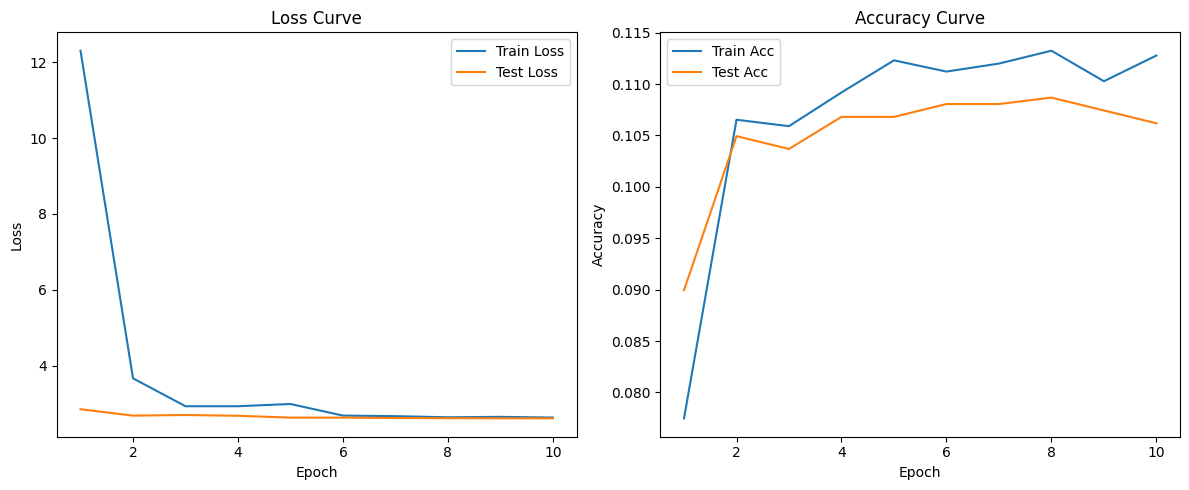

In [ ]:
best_acc = 0.0
train_losses, train_accs, test_losses, test_accs = [], [], [], []

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")
    # 记录
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_model_path)  # 确认save_model_path为字符串
print("Best Test Acc:", best_acc)
print(f"Best model saved to: {save_model_path}")

# 绘制训练&验证曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, label="Train Acc")
plt.plot(range(1, epochs + 1), test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("train_val_curve.png")
plt.show()